# Clinical trial design optimization 

## Loading dependencies

In [1]:
# Cookbook specifics imports
import jinko_helpers as jinko
import io
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as colors
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import KNeighborsRegressor, KDTree
from sklearn.preprocessing import StandardScaler
import zipfile
import textwrap
import lifelines

## Defining general parameters

In [2]:
# Jinko trial short ID, URL pattern is "https://jinko.ai/{trial_sid}"
trial_sid = "tr-A9YU-GXP2"
# Outcome ID
outcome_name = "ttp"
# control and treated arm IDs
control_arm_id = "Treated"
treated_arm_id = "Treated_DoubleDose"

"""
Sample size parameters
"""
alpha = 0.05
beta = 0.2

""" 
Efficacy measure. Depending on the use-case, 
"""


def efficacy(outcome_control, outcome_treated):
    return outcome_treated - outcome_control


class Descriptor:
    def __init__(self, identifier, arm=None):
        self.identifier = identifier
        self.arm = arm
        self.column_id = (
            self.identifier if self.arm is None else f"{self.identifier}_{self.arm}"
        )
        self.arm_id = "crossArms" if self.arm is None else self.arm
        self.lower_bound_id = f"{self.column_id}_lower_bound"
        self.width_id = f"{self.column_id}_width"

    def format_descriptor(self):
        if self.arm is not None:
            return f"{self.identifier} on arm {self.arm}"
        else:
            return self.identifier

    def set_lower_bound(self, lower_bound):
        self.lower_bound = lower_bound

    def set_upper_bound(self, upper_bound):
        self.upper_bound = upper_bound


all_descriptors = [
    Descriptor("immuneSystemAffinityConstant.tmin"),
    Descriptor("immuneSystemCatalyticConstant.tmin"),
    Descriptor("initialNumberOfTreatmentResistantCells.tmin"),
    Descriptor("livingCellsSuppliedByNeoangiogenesis.tmin"),
    Descriptor("tumorClone1:deltaCellProlifEq.tmin"),
]

""" Minimal size of the filtered responder vpop
(number of times the required sample size should be included in the responder vp in terms of nb of patients)
Will be evaluated for each set of eligibility criteria
"""
min_resp_vp_size = 1

"""
Objective function weights
"""
# weight of gross efficacy
efficacy_wt = 2
# weight of standard deviation of gross efficacy
efficacy_sd_wt = 1

"""
Boostrapping parameters
"""
## Number of bootstraps for gross efficacy dispersion estimation
num_bootstraps = 50
## Seed for all random processes
cookbook_seed = 2025

## Defining functions
### Sample size computation

In [3]:
## Sample size computation for "time to event" outcomes
def sample_size_tte(
    alpha,
    beta,
    follow_up_duration,
    hazard_ratio,
    med_surv_time_ctrl,
    allocation_ratio=1,
    recruitment_duration=0,
    censored_proportion=0,
):
    z_alpha = st.norm.ppf(1 - (alpha / 2))
    z_beta = st.norm.ppf(1 - beta)

    # HR in the control group
    lambda_control = np.log(2) / med_surv_time_ctrl

    # HR in the treatment group
    lambda_treatment = lambda_control / hazard_ratio

    # Overall event rate
    event_rate = lambda_control + allocation_ratio * lambda_treatment
    event_rate /= 1 + allocation_ratio  # Weighted average

    # Effective observation time (considering accrual and follow-up)
    total_time = recruitment_duration + follow_up_duration
    prob_event = (
        (1 - np.exp(-event_rate * follow_up_duration)) * follow_up_duration / total_time
    ) * (1 - censored_proportion)

    # Required number of events
    num_events = ((z_alpha + z_beta) ** 2 * (1 + allocation_ratio) ** 2) / (
        allocation_ratio * (np.log(hazard_ratio)) ** 2
    )

    # Total sample size
    total_sample_size = num_events / prob_event
    return total_sample_size

### Objective function

In [4]:
# Objective function to be maximized
def objective_function(
    efficacy,
    efficacy_sd,
):
    return (efficacy * efficacy_wt - efficacy_sd * efficacy_sd_wt) / (
        efficacy_wt + efficacy_sd_wt
    )

## Loading trial results from Jinko

In [5]:
jinko.initialize()

# Convert short id to core item id
trial_core_item_id = jinko.get_core_item_id(trial_sid, 1)


# Choose a specific revision. By default we return the last version
revision = None
# Choose a specific label. By default we return the last version
label = "cookbook"
response = jinko.get_project_item(sid=trial_sid, revision=revision, label=label)
trial_core_item_id, trial_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# Uncomment the following to get the latest completed version instead
# # List all trial versions
# # https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--status/get
# versions = jinko.make_request(
#     f'/core/v2/trial_manager/trial/{trial_core_item_id["id"]}/status'
# ).json()
# # Get the latest completed version
# try:
#     latest_completed_version = next(
#         (item for item in versions if item["status"] == "completed"), None
#     )
#     if latest_completed_version is None:
#         raise Exception("No completed trial version found")
#     else:
#         simulation_id = latest_completed_version["simulationId"]
#         trial_core_item_id = simulation_id["coreItemId"]
#         trial_snapshot_id = simulation_id["snapshotId"]
# except Exception as e:
#     print(f"Error processing trial versions: {e}")
#     raise

scalars_df = jinko.get_trial_scalars_as_dataframe(
    trial_core_item_id, trial_snapshot_id, scalar_ids=[d.identifier for d in all_descriptors] + [outcome_name]
)
print("Number of rows in the initial table:", len(scalars_df))

Authentication successful


Number of rows in the initial table: 69998


In [6]:
conditions = [
    (scalars_df["armId"] == d.arm_id) & (scalars_df["scalarId"] == d.identifier)
    for d in all_descriptors
]
unpivoted_descriptors_df = scalars_df[np.logical_or.reduce(conditions)]
for d in all_descriptors:
    row_filter = (unpivoted_descriptors_df["armId"] == d.arm_id) & (
        unpivoted_descriptors_df["scalarId"] == d.identifier
    )
    unpivoted_descriptors_df.loc[row_filter] = unpivoted_descriptors_df[
        row_filter
    ].assign(scalarId=d.column_id)
descriptors_df = unpivoted_descriptors_df.pivot(
    index="patientId", columns="scalarId", values="value"
)
outcome_control = (
    scalars_df[
        (scalars_df["armId"] == control_arm_id)
        & (scalars_df["scalarId"] == outcome_name)
    ]
    .assign(scalarId="outcome_control")
    .pivot(index="patientId", columns="scalarId", values="value")
)
outcome_treated = (
    scalars_df[
        (scalars_df["armId"] == treated_arm_id)
        & (scalars_df["scalarId"] == outcome_name)
    ]
    .assign(scalarId="outcome_treated")
    .pivot(index="patientId", columns="scalarId", values="value")
)
main_df = pd.merge(
    left=pd.merge(
        left=descriptors_df, right=outcome_control, how="left", on="patientId"
    ),
    right=outcome_treated,
    how="left",
    on="patientId",
).dropna()

<lifelines.CoxPHFitter: fitted with 19996 total observations, 782 right-censored observations>
             duration col = 'eventTime'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 19996
number of events observed = 19214
   partial log-likelihood = -173448.05
         time fit was run = 2025-05-27 07:49:04 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_treated -0.26      0.77      0.01           -0.29           -0.23                0.75                0.80

            cmp to      z      p  -log2(p)
covariate                                 
is_treated    0.00 -17.68 <0.005    229.88
---
Concordance = 0.52
Partial AIC = 346898.09
log-likelihood ratio test = 312.28 on 1 df
-log2(p) of ll-ratio test = 229.74

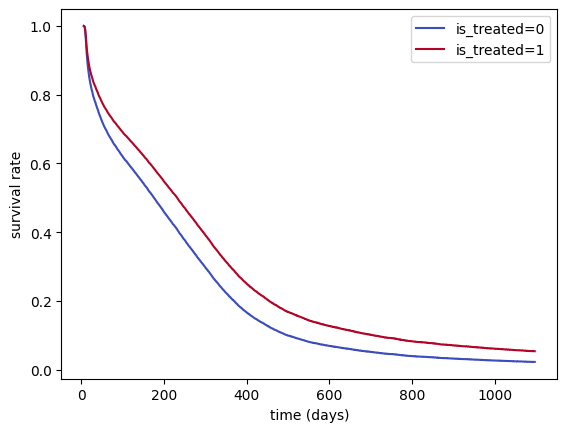

In [7]:
simulation_tmax = main_df["outcome_control"].max()


# we right-censor patients whose time to event >= simulation tmax
def right_censor(x):
    if x >= simulation_tmax - 1e-8:
        return 0
    else:
        return 1


def fit_survival(dataframe):
    survival_control = dataframe[["outcome_control"]].rename(
        columns={"outcome_control": "eventTime"}
    )
    survival_control["event"] = survival_control["eventTime"].apply(
        right_censor
    )
    survival_control["is_treated"] = 0
    survival_treated = dataframe[["outcome_treated"]].rename(
        columns={"outcome_treated": "eventTime"}
    )
    survival_treated["event"] = survival_treated["eventTime"].apply(right_censor)
    survival_treated["is_treated"] = 1
    survival_df = pd.concat([survival_control, survival_treated], ignore_index=True)
    survival_regression = lifelines.CoxPHFitter()
    survival_regression.fit(survival_df, duration_col="eventTime", event_col="event")
    return survival_regression, survival_df


def hazard_ratio(dataframe):
    survival_regression, _ = fit_survival(dataframe)
    ci_lower = survival_regression.summary["exp(coef) lower 95%"]["is_treated"]
    ci_upper = survival_regression.summary["exp(coef) upper 95%"]["is_treated"]
    return (survival_regression.hazard_ratios_["is_treated"], (ci_lower, ci_upper))


main_survival_regression, survival_df = fit_survival(main_df)
ax = main_survival_regression.plot_partial_effects_on_outcome(
    covariates="is_treated", values=[0, 1], cmap="coolwarm", plot_baseline=False
)
ax.set_xlabel("time (days)")
ax.set_ylabel("survival rate")
main_survival_regression.print_summary()
main_survival_regression.hazard_ratios_
trial_hazard_ratio = main_survival_regression.hazard_ratios_["is_treated"]
trial_ci_lower, trial_ci_upper = (
    main_survival_regression.summary["exp(coef) lower 95%"]["is_treated"],
    main_survival_regression.summary["exp(coef) upper 95%"]["is_treated"],
)

## Trial sample size

In [8]:
median_survival_time_control = main_df["outcome_control"].median()
print(f"Median survival time in control arm = {median_survival_time_control:.0f} days")
print(
    f"Median survival time in treated arm = {main_df["outcome_treated"].median():.0f} days"
)
print(
    f"Hazard ratio = {trial_hazard_ratio:.2f}, 95% CI = [{trial_ci_lower:.2f}, {trial_ci_upper:.2f}]"
)
trial_sample_size = math.ceil(
    sample_size_tte(
        alpha, beta, simulation_tmax, trial_hazard_ratio, median_survival_time_control
    )
)
print(f"Initial trial sample size = {trial_sample_size}")

Median survival time in control arm = 185 days
Median survival time in treated arm = 221 days
Hazard ratio = 0.77, 95% CI = [0.75, 0.80]
Initial trial sample size = 479


## Plotting score proxy

While the actual score function takes the average and standard deviation of the bootstrapped gross efficacy, this is 
rather costly to evaluate (because of the bootstraps).
Here, we leverage the fact that:

  1. the mean of the gross efficacy can be approximated by the mean of the absolute benefit 
  2. the variance of the gross efficacy can be approximated by '(var(outcome_control) + var(outcome_treated)) / sample_size'
to compute a so-called "score proxy"


Using a nearest-neighbor regression with "number of neighbors = sample_size * min_resp_vp_size", the Chebyshev norm and uniform weighting, 
we can compute a score proxy for each trial patient which approximates what the actual score sould be for 
a sub-population of size sample_size centered around each patient

Min score proxy = 2.7, max score proxy = 102


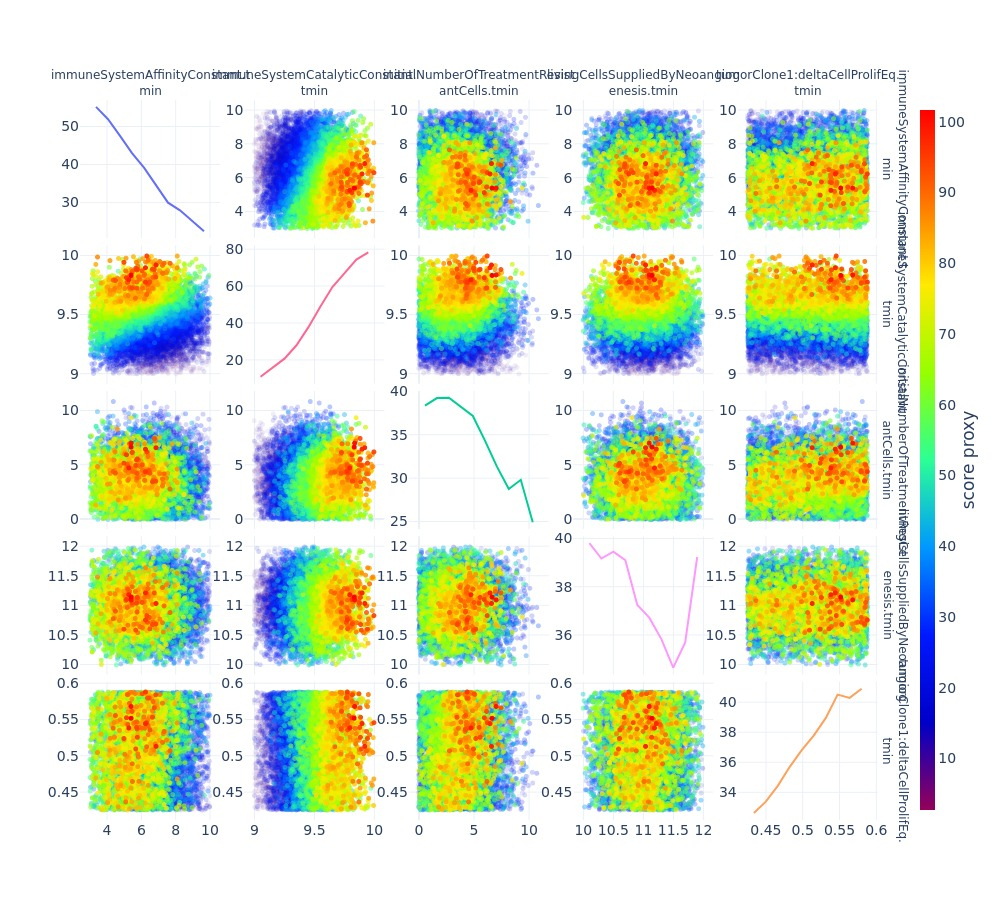

In [9]:
neigh_regressor = KNeighborsRegressor(
    n_neighbors=trial_sample_size * min_resp_vp_size,
    weights="uniform",
    metric="chebyshev",
    n_jobs=4,
)
X_unscaled = main_df[[d.column_id for d in all_descriptors]].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
score_proxy = main_df.copy(deep=True)
for arm in ["control", "treated"]:
    neigh_regressor.fit(
        X,
        score_proxy[f"outcome_{arm}"].to_numpy(),
    )
    score_proxy[f"mu_outcome_{arm}"] = neigh_regressor.predict(X)

    neigh_regressor.fit(
        X,
        (score_proxy[f"outcome_{arm}"].to_numpy()) ** 2,
    )
    score_proxy[f"mu_outcome_{arm}_squared"] = neigh_regressor.predict(X)
    score_proxy[f"var_outcome_{arm}"] = (
        score_proxy[f"mu_outcome_{arm}_squared"] - score_proxy[f"mu_outcome_{arm}"] ** 2
    )
# score proxy where the mean of gross efficacy is approximated using the mean of absolute benefit
# and the variance of gross efficacy is approximated as 'var(control) + var(treated) / sample_size'
score_proxy["score_proxy"] = objective_function(
    efficacy(score_proxy[f"mu_outcome_control"], score_proxy[f"mu_outcome_treated"]),
    np.sqrt(score_proxy[f"var_outcome_control"] + score_proxy[f"var_outcome_treated"])
    / np.sqrt(trial_sample_size),
)
min_score, max_score = (
    score_proxy["score_proxy"].min(),
    score_proxy["score_proxy"].max(),
)
print(f"Min score proxy = {min_score:.3g}, max score proxy = {max_score:.3g}")

score_proxy = score_proxy.sort_values(by="score_proxy")
num_features = len(all_descriptors)
features_wrapped = [
    "<br>".join(textwrap.wrap(t.identifier, width=30)) for t in all_descriptors
]
fig = make_subplots(
    num_features,
    num_features,
    shared_xaxes=True,
    shared_yaxes=False,
    horizontal_spacing=0.03,
    vertical_spacing=0.01,
    column_titles=features_wrapped,
    row_titles=features_wrapped,
)

for i in range(num_features):  # iterating over rows
    for j in range(num_features):  # iterating over columns
        if i == j:  # do not plot anything on the diagonal
            x = score_proxy[all_descriptors[i].column_id]
            nx = 10
            xs = np.linspace(x.min(), x.max(), nx + 1)
            y = []
            for k in range(nx):
                eff_k = score_proxy[
                    (score_proxy[all_descriptors[i].column_id] >= xs[k])
                    & (score_proxy[all_descriptors[i].column_id] < xs[k + 1])
                ]["score_proxy"]
                y.append(eff_k.mean())
            fig.add_trace(
                go.Scatter(x=xs[:-1] + 0.5 * (xs[1] - xs[0]), y=y, mode="lines"),
                row=i + 1,
                col=j + 1,
            )
        else:
            fig.add_trace(
                go.Scattergl(
                    x=score_proxy[all_descriptors[j].column_id],
                    y=score_proxy[all_descriptors[i].column_id],
                    mode="markers",
                    marker=dict(
                        size=5,
                        color=score_proxy["score_proxy"],
                        opacity=(score_proxy["score_proxy"] - min_score)
                        / (max_score - min_score),
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j + 1,
            )
fig.update_annotations(font_size=12)
fig.update_coloraxes(
    colorbar_title="score proxy",
    cmin=min_score,
    cmax=max_score,
    colorscale="rainbow",
    colorbar_thickness=15,
    colorbar_title_side="right",
)
fig.update_layout(
    font=dict(size=14),
    showlegend=False,
    width=1000,
    height=900,
    template="plotly_white",
)
fig.show(renderer="jpeg")

## Selecting features

In [10]:
num_features = min(5, len(all_descriptors))
features = all_descriptors[:num_features]
print(f"Selected features: {[feature.identifier for feature in features]}")

for descriptor in features:
    descriptor.set_lower_bound(main_df[descriptor.column_id].min())
    descriptor.set_upper_bound(main_df[descriptor.column_id].max())


class EligibilityCriteria:
    def __init__(self, descriptors: list[Descriptor]):
        self.descriptors = descriptors
        self.criteria_ids = [
            descriptor.lower_bound_id for descriptor in descriptors
        ] + [descriptor.width_id for descriptor in descriptors]
        self.bounds = {}
        for descriptor in descriptors:
            (d_min, d_max) = (descriptor.lower_bound, descriptor.upper_bound)
            self.bounds[descriptor.lower_bound_id] = (
                d_min,
                d_max - 0.1 * (d_max - d_min),
            )
            self.bounds[descriptor.width_id] = (0.1 * (d_max - d_min), d_max - d_min)

    def column_ids(self):
        return [descriptor.column_id for descriptor in ec.descriptors]

    def criteria_from_vector(self, vec: list[float]) -> dict:
        return {criterion_id: x for (criterion_id, x) in zip(self.criteria_ids, vec)}

    def criteria_to_vector(self, criteria: dict) -> list[float]:
        vec = np.zeros((len(self.criteria_ids),))
        for i, criteria_id in enumerate(self.criteria_ids):
            vec[i] = criteria[criteria_id]
        return vec

    def filter_conditions(self, dataframe, criteria):
        conditions = [
            (dataframe[descriptor.column_id] >= criteria[descriptor.lower_bound_id])
            & (
                dataframe[descriptor.column_id]
                <= criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]
            )
            for descriptor in self.descriptors
        ]
        return np.logical_and.reduce(conditions)

    def format_criteria(self, criteria):
        s = ""
        for descriptor in self.descriptors:
            s += f"\n {criteria[descriptor.lower_bound_id]:.3g} <= {descriptor.format_descriptor()} <= {criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]:.3g}"
        return s

    # returns the mean and standard deviation of the gross efficacy using the absolute benefit
    def gross_efficacy_using_absolute_benefit(self, dataframe, criteria, sample_size):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        if len(filtered_df) < sample_size * min_resp_vp_size:
            return (None, None)
        control_filtered = filtered_df["outcome_control"]
        treated_filtered = filtered_df["outcome_treated"]
        mean_efficacy = efficacy(control_filtered.mean(), treated_filtered.mean())
        var_efficacy = (control_filtered.var() + treated_filtered.var()) / sample_size

        return (mean_efficacy, np.sqrt(var_efficacy))

    def score_vector(self, dataframe, sample_size, x):
        criteria = self.criteria_from_vector(x)
        (mean_ge, sd_ge) = ec.gross_efficacy_using_absolute_benefit(
            dataframe, criteria, sample_size
        )
        if mean_ge is not None and sd_ge is not None:
            return objective_function(mean_ge, sd_ge)
        else:
            return np.nan

    def group_size(self, dataframe, criteria):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        return len(filtered_df)

    def report(self, dataframe, criteria):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        print(
            f"\nMedian survival time in control arm = {filtered_df["outcome_control"].median():.0f} days"
        )
        print(
            f"Median survival time in treated arm = {filtered_df["outcome_treated"].median():.0f} days"
        )
        hr, (ci_lower, ci_upper) = hazard_ratio(filtered_df)
        print(f"Hazard ratio = {hr:.2f}, 95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")


ec = EligibilityCriteria(descriptors=features)

Selected features: ['immuneSystemAffinityConstant.tmin', 'immuneSystemCatalyticConstant.tmin', 'initialNumberOfTreatmentResistantCells.tmin', 'livingCellsSuppliedByNeoangiogenesis.tmin', 'tumorClone1:deltaCellProlifEq.tmin']


## Eligibility criteria optimization using score proxy

In [11]:
imax = score_proxy["score_proxy"].argmax()
print(f"Best score proxy = {score_proxy.iloc[imax]["score_proxy"]:.3g}")
x0_unscaled = score_proxy.iloc[imax][ec.column_ids()].to_numpy()

X_unscaled = score_proxy[ec.column_ids()].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
neigh_regressor.fit(X, score_proxy["outcome_control"].to_numpy())

x0_scaled = feature_scaler.transform(np.reshape(x0_unscaled, (1, x0_unscaled.size)))
distances, indices = neigh_regressor.kneighbors(
    x0_scaled, n_neighbors=trial_sample_size * min_resp_vp_size
)
score_proxy_criteria = {}
for i, descriptor in enumerate(ec.descriptors):
    min_f, max_f = np.amin(X_unscaled[indices[0, :], i]), np.amax(
        X_unscaled[indices[0, :], i]
    )
    score_proxy_criteria[descriptor.lower_bound_id] = min_f
    width = max_f - min_f + 1e-12  # FIXME
    score_proxy_criteria[descriptor.width_id] = width


print(ec.format_criteria(score_proxy_criteria))
ec.report(main_df, score_proxy_criteria)

Best score proxy = 102

 3.29 <= immuneSystemAffinityConstant.tmin <= 7.51
 9.56 <= immuneSystemCatalyticConstant.tmin <= 10
 3.77 <= initialNumberOfTreatmentResistantCells.tmin <= 9.53
 10.6 <= livingCellsSuppliedByNeoangiogenesis.tmin <= 11.7
 0.483 <= tumorClone1:deltaCellProlifEq.tmin <= 0.588

Median survival time in control arm = 206 days
Median survival time in treated arm = 254 days
Hazard ratio = 0.53, 95% CI = [0.47, 0.61]


### Monte Carlo fine tuning

In [12]:
rng = np.random.default_rng([cookbook_seed])
num_mc = 10000
exploration_scale = 0.02

x0 = ec.criteria_to_vector(score_proxy_criteria)
dim = len(ec.criteria_ids)
X_mc = rng.normal(loc=x0, scale=np.absolute(x0 * exploration_scale), size=(num_mc, dim))
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in X_mc])
mc_i_max = np.nanargmax(y)
print(
    f"MC fine-tuning, number of admissible points = {np.count_nonzero(~np.isnan(y))} / {X_mc.shape[0]}"
)
score_proxy_mc_fine_tuned_criteria = ec.criteria_from_vector(X_mc[mc_i_max])
ec.report(
    main_df,
    score_proxy_mc_fine_tuned_criteria,
)

MC fine-tuning, number of admissible points = 4610 / 10000

Median survival time in control arm = 202 days
Median survival time in treated arm = 254 days
Hazard ratio = 0.54, 95% CI = [0.47, 0.62]


## Eligibility criteria optimization using Sobol sequence grid search + MC fine tuning

### Sobol sequence grid search

In [13]:
sampler = st.qmc.Sobol(dim, scramble=False)
m = 14
print(f"Full design size = {2**m}")
scaled_samples = sampler.random_base2(m)  # generates 2**m points


def unscale(x):
    return st.qmc.scale(
        x,
        [ec.bounds[c][0] for c in ec.criteria_ids],
        [ec.bounds[c][1] for c in ec.criteria_ids],
    )


def scale(x):
    return st.qmc.scale(
        x,
        [ec.bounds[c][0] for c in ec.criteria_ids],
        [ec.bounds[c][1] for c in ec.criteria_ids],
        reverse=True,
    )


samples = unscale(scaled_samples)
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in samples])
print(
    f"Number of admissible points = {np.count_nonzero(~np.isnan(y))} / {samples.shape[0]}"
)
exhaustive_i_max = np.nanargmax(y)
exhaustive_best_criteria = ec.criteria_from_vector(samples[exhaustive_i_max])
ec.report(
    main_df,
    exhaustive_best_criteria,
)

Full design size = 16384
Number of admissible points = 839 / 16384

Median survival time in control arm = 196 days
Median survival time in treated arm = 240 days
Hazard ratio = 0.55, 95% CI = [0.49, 0.63]


### MC fine-tuning

After having found the best point in the Sobol design of experiment, let's search for an even better set of
eligibility criteria around said point

In [14]:
tree = KDTree(scaled_samples)
k = 10
x0 = scaled_samples[exhaustive_i_max, :]
distances, indices = tree.query(np.reshape(x0, (1, x0.size)), k=k)
# distance to kth nearest neighbor
radius = distances[0, k - 1]

rng = np.random.default_rng([cookbook_seed])
num_mc = 10000
# the average squared distance from the mean in a multivariate normal distribution is tr(Σ)
# so by choosing a standard deviation of sigma = radius / sqrt(dim), our sampled points will lie in average
# at a distance of radius from x0
scaled_mc = rng.normal(loc=x0, scale=radius / np.sqrt(dim), size=(num_mc, dim))
scaled_mc[scaled_mc < 0] = 0
scaled_mc[scaled_mc > 1] = 1
X_mc = unscale(scaled_mc)
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in X_mc])
mc_i_max = np.nanargmax(y)
print(
    f"MC fine-tuning, number of admissible points = {np.count_nonzero(~np.isnan(y))} / {X_mc.shape[0]}"
)
exhaustive_mc_fine_tuned_criteria = ec.criteria_from_vector(X_mc[mc_i_max])
ec.report(
    main_df,
    exhaustive_mc_fine_tuned_criteria,
)

MC fine-tuning, number of admissible points = 3496 / 10000

Median survival time in control arm = 179 days
Median survival time in treated arm = 228 days
Hazard ratio = 0.53, 95% CI = [0.46, 0.61]


## Potential gains

Hazard ratio in initial population = 0.77, 95% CI = [0.75, 0.80]
Median survival time in control arm = 185 days
Median survival time in treated arm = 221 days
Required sample size in initial population = 479

Eligibility criteria using Sobol design exhaustive search + MC fine-tuning:
  Number of unique best responding patients: 504
  Median survival time in control arm = 179 days
  Median survival time in treated arm = 228 days
  Hazard ratio = 0.53, 95% CI = [0.46, 0.61]
  Required sample size in population of best responders = 79


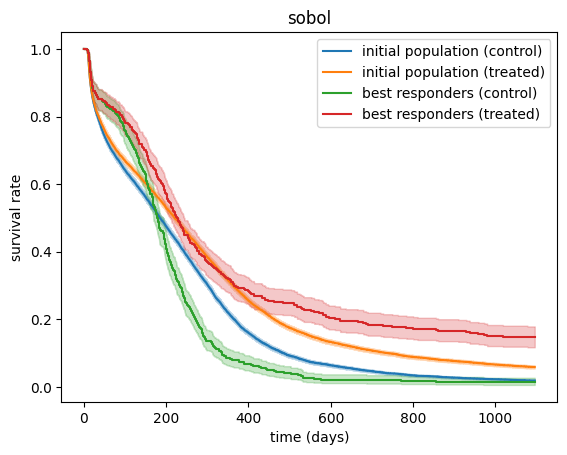


Eligibility criteria using score proxy + MC fine-tuning:
  Number of unique best responding patients: 482
  Median survival time in control arm = 202 days
  Median survival time in treated arm = 254 days
  Hazard ratio = 0.54, 95% CI = [0.47, 0.62]
  Required sample size in population of best responders = 83


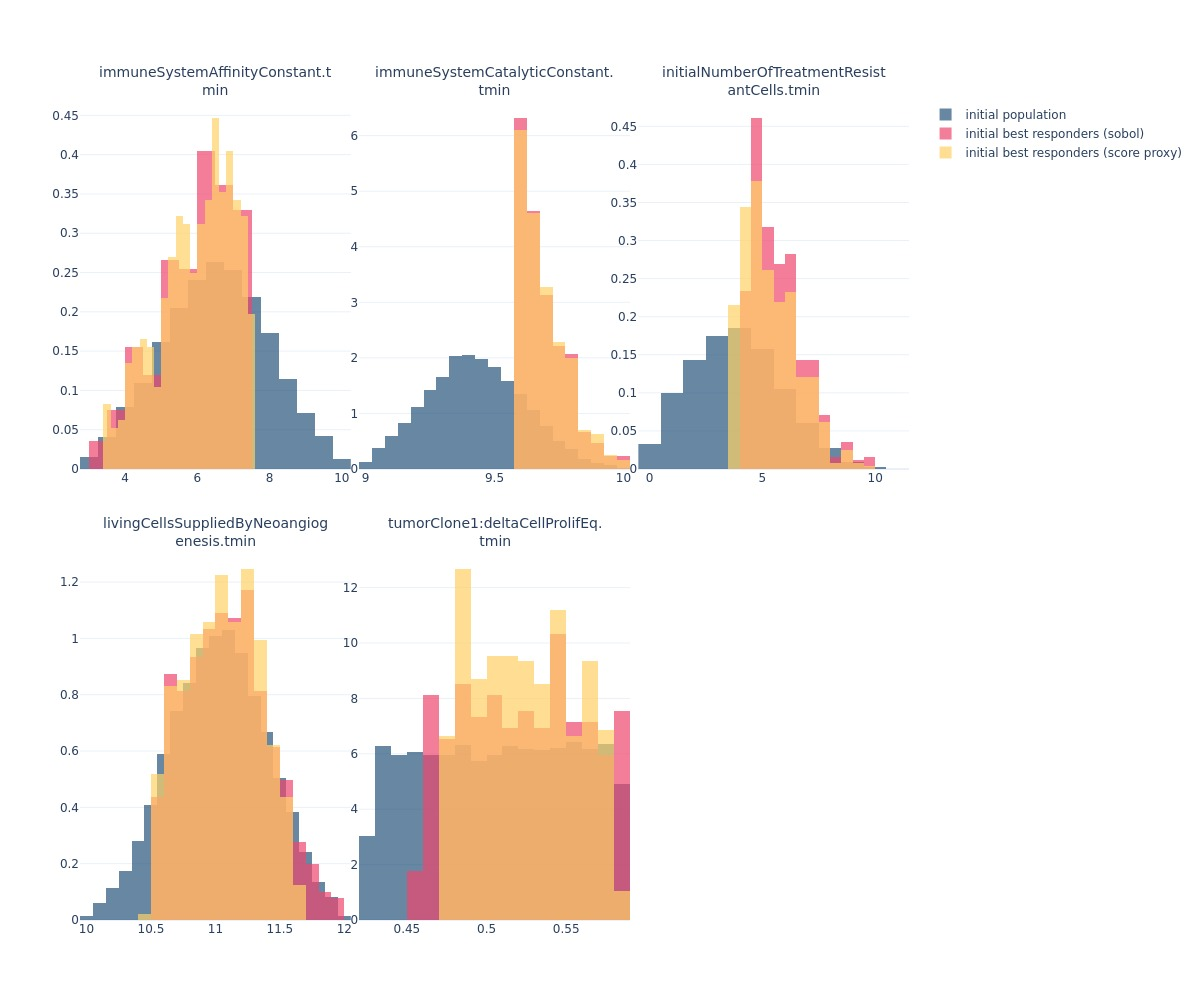

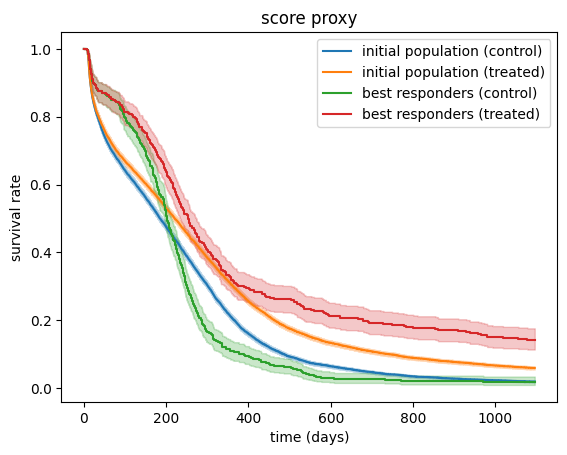

In [15]:
def print_report(criteria, method):
    num_responding = ec.group_size(main_df, criteria)
    print(f"  Number of unique best responding patients: {num_responding}")
    filtered_df = main_df[ec.filter_conditions(main_df, criteria)]
    median_survival_time_control = filtered_df["outcome_control"].median()
    print(
        f"  Median survival time in control arm = {median_survival_time_control:.0f} days"
    )
    print(
        f"  Median survival time in treated arm = {filtered_df["outcome_treated"].median():.0f} days"
    )
    hr, (ci_lower, ci_upper) = hazard_ratio(filtered_df)
    print(f"  Hazard ratio = {hr:.2f}, 95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")
    _, main_survival_df = fit_survival(main_df)
    regressor, filtered_survival_df = fit_survival(filtered_df)

    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(durations=main_survival_df.loc[main_survival_df["is_treated"]==0]["eventTime"], event_observed=main_survival_df.loc[main_survival_df["is_treated"]==0]["event"], label="initial population (control)")
    ax = kmf.plot_survival_function()
    kmf.fit(durations=main_survival_df.loc[main_survival_df["is_treated"]==1]["eventTime"], event_observed=main_survival_df.loc[main_survival_df["is_treated"]==1]["event"], label="initial population (treated)")
    kmf.plot_survival_function(ax=ax)
    kmf.fit(durations=filtered_survival_df.loc[filtered_survival_df["is_treated"]==0]["eventTime"], event_observed=filtered_survival_df.loc[filtered_survival_df["is_treated"]==0]["event"], label="best responders (control)")
    ax = kmf.plot_survival_function()
    kmf.fit(durations=filtered_survival_df.loc[filtered_survival_df["is_treated"]==1]["eventTime"], event_observed=filtered_survival_df.loc[filtered_survival_df["is_treated"]==1]["event"], label="best responders (treated)")
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel("time (days)")
    ax.set_ylabel("survival rate")
    ax.set_title(f"{method}")
    sample_size = math.ceil(
        sample_size_tte(
            alpha,
            beta,
            simulation_tmax,
            regressor.hazard_ratios_["is_treated"],
            median_survival_time_control,
        )
    )
    print(f"  Required sample size in population of best responders = {sample_size}")


print(
    f"Hazard ratio in initial population = {trial_hazard_ratio:.2f}, 95% CI = [{trial_ci_lower:.2f}, {trial_ci_upper:.2f}]"
)

print(
    f"Median survival time in control arm = {main_df["outcome_control"].median():.0f} days"
)
print(
    f"Median survival time in treated arm = {main_df["outcome_treated"].median():.0f} days"
)
print(f"Required sample size in initial population = {trial_sample_size}")

print("\nEligibility criteria using Sobol design exhaustive search + MC fine-tuning:")
print_report(exhaustive_mc_fine_tuned_criteria, method="sobol")
plt.show()

print("\nEligibility criteria using score proxy + MC fine-tuning:")
print_report(score_proxy_mc_fine_tuned_criteria, method="score proxy")


# Histogram plots


def feature_histogram(fig, name, i, j, x, marker_color):
    fig.add_trace(
        go.Histogram(
            name=name,
            x=x,
            histnorm="probability density",
            nbinsx=num_histogram_bins,
            marker_color=marker_color,
            showlegend=show_legend,
        ),
        row=i + 1,
        col=j + 1,
    )


colnames = [f.format_descriptor() for f in features]
dimension = len(colnames)
colnames_wrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in colnames]
num_rows, num_cols = 2, 3
if num_rows * num_cols < dimension:
    raise Exception(
        f"Not enough rows and columns ({num_rows * num_cols = }) to plot {dimension} parameters"
    )
num_histogram_bins = 21

fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    horizontal_spacing=0.01,
    vertical_spacing=0.1,
    subplot_titles=colnames_wrapped,
)
show_legend = True
for i in range(num_rows):
    for j in range(num_cols):
        k = num_cols * i + j
        if k >= dimension:
            continue
        else:
            feature = features[k]
            feature_histogram(
                fig, "initial population", i, j, main_df[feature.column_id], "#26547C"
            )
            feature_histogram(
                fig,
                "initial best responders (sobol)",
                i,
                j,
                main_df.loc[
                    ec.filter_conditions(main_df, exhaustive_mc_fine_tuned_criteria)
                ][feature.column_id],
                "#EF476F",
            )
            feature_histogram(
                fig,
                "initial best responders (score proxy)",
                i,
                j,
                main_df.loc[
                    ec.filter_conditions(main_df, score_proxy_mc_fine_tuned_criteria)
                ][feature.column_id],
                "#FFD166",
            )
            show_legend = False
fig.update_annotations(font_size=14)
figure_width = 1200
figure_height = 1000
fig.update_layout(
    font=dict(size=12),
    showlegend=True,
    barmode="overlay",
    width=figure_width,
    height=figure_height,
    template="plotly_white",
)
fig.update_traces(opacity=0.7)
fig.show(renderer="jpeg")

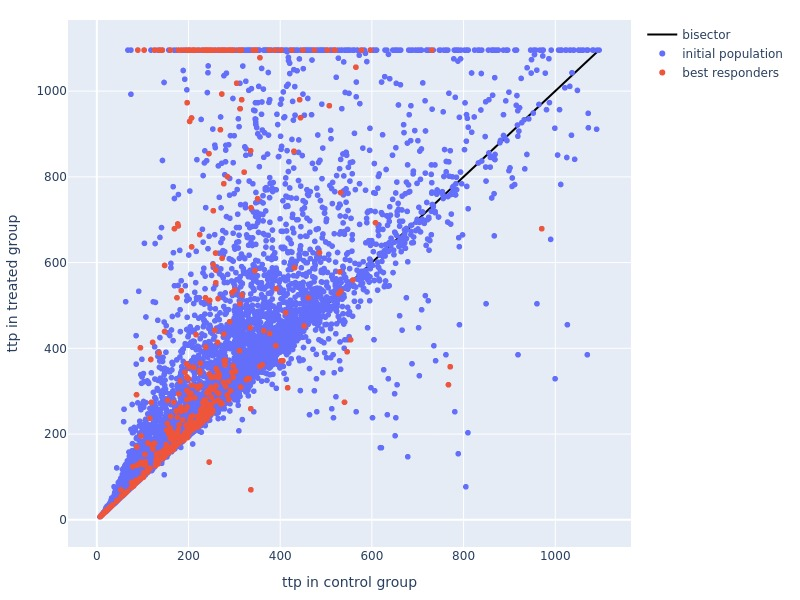

In [16]:
fig = go.Figure()
outcome = main_df["outcome_control"]
bisector = np.array([outcome.min(), outcome.max()])
fig.add_trace(
    go.Scatter(
        x=bisector, y=bisector, mode="lines", line_color="black", name="bisector"
    )
)
# we remove right-censored patients on the control arm for the scatter plot
scatter_plot_df = main_df.loc[main_df["outcome_control"] < simulation_tmax - 1e-8]
fig.add_trace(
    go.Scattergl(
        x=scatter_plot_df["outcome_control"],
        y=scatter_plot_df["outcome_treated"],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[0],
        ),
        name="initial population",
        hoverinfo="none",
    )
)
fig.add_trace(
    go.Scattergl(
        x=scatter_plot_df[
            ec.filter_conditions(scatter_plot_df, score_proxy_mc_fine_tuned_criteria)
        ]["outcome_control"],
        y=scatter_plot_df[
            ec.filter_conditions(scatter_plot_df, score_proxy_mc_fine_tuned_criteria)
        ]["outcome_treated"],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[1],
        ),
        name="best responders",
        hoverinfo="none",
    )
)
fig.update_xaxes(title_text=f"{outcome_name} in control group")
fig.update_yaxes(title_text=f"{outcome_name} in treated group")
fig.update_annotations(font_size=12)
fig.update_layout(
    showlegend=True,
    width=800,
    height=600,
    margin=dict(l=50, r=20, t=20, b=20),
)
fig.show(renderer="jpeg")